In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from scipy.ndimage import interpolation as inter

In [2]:
def correct_skew(image, delta=1, limit=5):
    def determine_score(arr, angle):
        data = inter.rotate(arr, angle, reshape=False, order=0)
        histogram = np.sum(data, axis=1)
        score = np.sum((histogram[1:] - histogram[:-1]) ** 2)
        return histogram, score

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1] 

    scores = []
    angles = np.arange(-limit, limit + delta, delta)
    for angle in angles:
        histogram, score = determine_score(thresh, angle)
        scores.append(score)

    best_angle = angles[scores.index(max(scores))]

    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, best_angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, \
              borderMode=cv2.BORDER_REPLICATE)

    return best_angle, rotated

In [3]:
#reading the original image using OpenCV
image = cv2.imread('Original.jpg')

In [4]:
#Converting the colored image to greyscale
angle, rotated = correct_skew(image)
print(angle)
cv2.imwrite('rotated.jpg', rotated)
gray = cv2.cvtColor(rotated,cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

C:\Users\sarad\AppData\Local\Temp\ipykernel_3260\3330985539.py:3: DeprecationWarning: Please use `rotate` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  data = inter.rotate(arr, angle, reshape=False, order=0)


-1


In [5]:
# Remove horizontal lines
horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (40,1))
remove_horizontal = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, horizontal_kernel, iterations=2)
cnts = cv2.findContours(remove_horizontal, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
for c in cnts:
    cv2.drawContours(rotated, [c], -1, (255,255,255), 5)

In [6]:
# Remove vertical lines
vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1,40))
remove_vertical = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, vertical_kernel, iterations=2)
cnts = cv2.findContours(remove_vertical, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
for c in cnts:
    cv2.drawContours(rotated, [c], -1, (255,255,255), 5)

In [7]:
gray = cv2.cvtColor(rotated,cv2.COLOR_BGR2GRAY)

In [8]:
#applying median filter for Salt and pepper/impulse noise
filter1 = cv2.medianBlur(gray,5)

In [9]:
#applying gaussian blur to smoothen out the image edges
filter2 = cv2.GaussianBlur(filter1,(5,5),0)

In [10]:
#applying non-localized means for final Denoising of the image
dst = cv2.fastNlMeansDenoising(filter2,None,17,9,17)

In [11]:
#converting the image to binarized form using adaptive thresholding
th1 = cv2.adaptiveThreshold(dst,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)

In [12]:
cv2.imwrite('ImagePreProcessingFinal.jpg', th1)

True

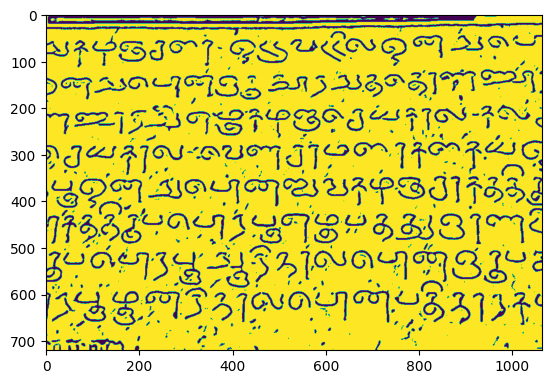

In [13]:
plt.imshow(th1)

In [14]:
import cv2
import os
import numpy as np
import imutils
import matplotlib.pyplot as plt

In [15]:
pip install imutils

Note: you may need to restart the kernel to use updated packages.


In [16]:
image = cv2.imread("ImagePreProcessingFinal.jpg")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (7, 7), 0)

In [17]:
ret,thresh1 = cv2.threshold(gray ,127,255,cv2.THRESH_BINARY_INV)

In [18]:
dilate = cv2.dilate(thresh1, None, iterations=2)

In [19]:
cnts = cv2.findContours(dilate.copy(), cv2.RETR_EXTERNAL,
    cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[1] if imutils.is_cv2() else cnts[0]

In [20]:
sorted_ctrs = sorted(cnts, key=lambda ctr: cv2.boundingRect(ctr)[0] + cv2.boundingRect(ctr)[1] * image.shape[1] )

In [39]:
orig = image.copy()
i = 0
fig =plt.figure(figsize = (10,10))

directory = r'D:\Projects\Tamil Character Recognition\cnn\test'

print(os.chdir(directory))
print(os.getcwd())
for cnt in sorted_ctrs:
#     print(cv2.contourArea(cnt))
    # Check the area of contour, if it is very small ignore it
    if(cv2.contourArea(cnt) < 200):
        continue
    
    # Filtered countours are detected
    x,y,w,h = cv2.boundingRect(cnt)
    
    # Taking ROI of the cotour
    roi = image[y:y+h, x:x+w]
    
    # Mark them on the image if you want
    cv2.rectangle(orig,(x,y),(x+w,y+h),(0,255,0),2)
    
    # Save your contours or characters
    print(cv2.imwrite(r"D:\Projects\Tamil Character Recognition\cnn\test" + str(i) + ".png", roi))
    
    
    i = i + 1 

AttributeError: module 'keras.api._v2.keras.preprocessing.image' has no attribute 'copy'

In [22]:
cv2.imwrite("box.jpg",orig)

True

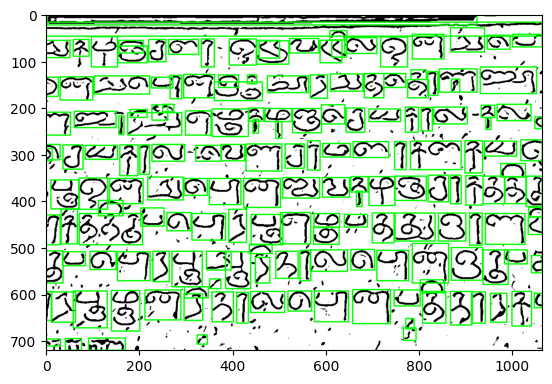

In [23]:
plt.imshow(orig)

In [24]:
from tensorflow.keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
import numpy as np
from sklearn.cluster import KMeans
import os, shutil, glob, os.path
from PIL import Image as pil_image
image.LOAD_TRUNCATED_IMAGES = True

In [25]:
model = VGG16(weights='imagenet', include_top=False)

In [47]:
imdir = r'D:\Projects\Tamil Character Recognition\cnn\test'
os.chdir(imdir)
targetdir = r'D:\Projects\Tamil Character Recognition\cnn\imagee'
number_clusters = 28

In [40]:
# Loop over files and get features
filelist = glob.glob(os.path.join(imdir, '*.PNG'))
filelist.sort()
featurelist = []
labels = []
print(filelist)

['D:\\Projects\\Tamil Character Recognition\\cnn\\test\\test0.png', 'D:\\Projects\\Tamil Character Recognition\\cnn\\test\\test1.png', 'D:\\Projects\\Tamil Character Recognition\\cnn\\test\\test10.png', 'D:\\Projects\\Tamil Character Recognition\\cnn\\test\\test100.png', 'D:\\Projects\\Tamil Character Recognition\\cnn\\test\\test101.png', 'D:\\Projects\\Tamil Character Recognition\\cnn\\test\\test102.png', 'D:\\Projects\\Tamil Character Recognition\\cnn\\test\\test103.png', 'D:\\Projects\\Tamil Character Recognition\\cnn\\test\\test104.png', 'D:\\Projects\\Tamil Character Recognition\\cnn\\test\\test105.png', 'D:\\Projects\\Tamil Character Recognition\\cnn\\test\\test106.png', 'D:\\Projects\\Tamil Character Recognition\\cnn\\test\\test107.png', 'D:\\Projects\\Tamil Character Recognition\\cnn\\test\\test108.png', 'D:\\Projects\\Tamil Character Recognition\\cnn\\test\\test109.png', 'D:\\Projects\\Tamil Character Recognition\\cnn\\test\\test11.png', 'D:\\Projects\\Tamil Character Recognit

In [48]:
for i, imagepath in enumerate(filelist):
    print("Status: %s / %s" %(i+1, len(filelist)), end="\r")
    img = image.load_img(imagepath, target_size=(224, 224))
    imagepath = imagepath.replace("\\", "/")
    print(imagepath)    
    start = (imagepath[5:]).index("/")
    end = (imagepath[5+1+start:]).index("/")
    labels.append(imagepath[52+start:52+start+end])  
    
    img_data = image.img_to_array(img)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)
    features = np.array(model.predict(img_data))
    featurelist.append(features.flatten())

print("Labels - ", labels)

D:/Projects/Tamil Character Recognition/cnn/test/test0.png
1/1 [==============================] - 0s 238ms/step
D:/Projects/Tamil Character Recognition/cnn/test/test1.png
1/1 [==============================] - 0s 176ms/step
D:/Projects/Tamil Character Recognition/cnn/test/test10.png
1/1 [==============================] - 0s 303ms/step
D:/Projects/Tamil Character Recognition/cnn/test/test100.png
1/1 [==============================] - 0s 195ms/step
D:/Projects/Tamil Character Recognition/cnn/test/test101.png
1/1 [==============================] - 0s 197ms/step
D:/Projects/Tamil Character Recognition/cnn/test/test102.png
1/1 [==============================] - 0s 177ms/step
D:/Projects/Tamil Character Recognition/cnn/test/test103.png
1/1 [==============================] - 0s 171ms/step
D:/Projects/Tamil Character Recognition/cnn/test/test104.png
1/1 [==============================] - 0s 164ms/step
D:/Projects/Tamil Character Recognition/cnn/test/test105.png
1/1 [===========================

In [49]:
# Loop over files and get features
filelist = glob.glob(os.path.join(imdir, '*.PNG'))
filelist.sort()
featurelist = []
labels = []

for i, imagepath in enumerate(filelist):
    print("Status: %s / %s" %(i+1, len(filelist)), end="\r")
    img = image.load_img(imagepath, target_size=(224, 224))
    
    # Replace backslashes with forward slashes for consistency
    imagepath = imagepath.replace("\\", "/")
    
    # Split the image path using forward slashes
    path_parts = imagepath.split("/")
    
    # Extract the label from the path
    label = path_parts[-2]  # Assuming the label is the second last part of the path
    labels.append(label)
    
    img_data = image.img_to_array(img)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)
    features = np.array(model.predict(img_data))
    featurelist.append(features.flatten())

print("Labels:", labels)


1/1 [==============================] - 0s 164ms/step
Labels: ['test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 't

In [50]:
# Clustering
kmeans = KMeans(n_clusters=number_clusters, random_state=0).fit(np.array(featurelist))

C:\Users\sarad\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [51]:
try:
    os.makedirs(targetdir)
except OSError:
    pass

In [52]:
print("\n")
for i, m in enumerate(kmeans.labels_):
    try:
        os.makedirs(targetdir+'\\'+str(m))
        #print(m)
    except OSError:
        pass
    print("Copy: %s / %s" %(i+1, len(kmeans.labels_)), end="\r")
    shutil.copy(filelist[i], targetdir +'/'+ str(m) + "/" + str(i) + ".jpg")